In [ ]:
#all_slow

# Tutorial: Fine-Tuning Token Classification on DataFrames with CoNLL 2003
> Tuning a Token Classification (Named Entity Recognition) model on the CoNLL 2003 dataset

## Introduction

In this tutorial we will be showing an end-to-end example of fine-tuning a Transformer for token classification on a custom dataset in DataFrame format.

By the end of this you should be able to:

1. Build a dataset with the `TokenClassificationDatasets` class, and its DataLoaders
2. Build a `TokenClassificationTuner` quickly, find a good learning rate, and train with the One-Cycle Policy
3. Save that model away, to be used with deployment or other HuggingFace libraries
4. Apply inference using both the `Tuner`'s available function as well as with the `EasyTokenTagger` class within AdaptNLP


## Installing the Library

This tutorial utilizies the latest AdaptNLP version, as well as parts of the `fastai` library. Please run the below code to install them:

```python
!pip install adaptnlp -U
```
(or `pip3`)

In [ ]:
#hide
from nbverbose.showdoc import *

## Getting the Dataset

First we need a dataset. We will use the `HuggingFace` library to download the `conll2003` dataset and convert it to a `pandas` DataFrame. This may seem counterintuitive, but it works for demonstrational purposes. In practice you would use a custom `pandas` DataFrame.

`CoNLL 2003` is a named entity recognition (NER) dataset which contains the following named entities: persons, locations, organizations, and names of miscellaneous entities that do not belong to the previous three groups. It follows the IOB2 tagging scheme.

In [ ]:
from datasets import load_dataset

dsets = load_dataset('conll2003')

Reusing dataset conll2003 (/home/ubuntu/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6)


For the purpose of example, we'll take the train subset, convert it to a `pandas` DataFrame, and grab the `tokens` and `ner_tags` columns, which will serve as our tokens and labels.

In [ ]:
dset = dsets['train']
dset.set_format(type='pandas')
df = dset[:]
df = df[['tokens', 'ner_tags']]

Let's look at our data

In [ ]:
df.head()

,tokens,ner_tags
0,"[EU, rejects, German, call, to, boycott, Briti...","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,"[Peter, Blackburn]","[1, 2]"
2,"[BRUSSELS, 1996-08-22]","[5, 0]"
3,"[The, European, Commission, said, on, Thursday...","[0, 3, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, ..."
4,"[Germany, 's, representative, to, the, Europea...","[5, 0, 0, 0, 0, 3, 4, 0, 0, 0, 1, 2, 0, 0, 0, ..."


Now that we've downloaded some data, let's pick a viable model to train with

## Picking a Model with the Hub

AdaptNLP has a `HFModelHub` class that allows you to communicate with the HuggingFace Hub and pick a model from it, as well as a namespace `HF_TASKS` class with a list of valid tasks we can search by.

Let's try and find one suitable for token classification.

First we need to import the class and generate an instance of it:

In [ ]:
from adaptnlp import HFModelHub, HF_TASKS

In [ ]:
hub = HFModelHub()

Next we can search for a model:

In [ ]:
models = hub.search_model_by_task(HF_TASKS.TOKEN_CLASSIFICATION)

Let's look at a few:

In [ ]:
models[:10]

[Model Name: xlm-roberta-large-finetuned-conll03-english, Tasks: [token-classification],
 Model Name: xlm-roberta-large-finetuned-conll03-german, Tasks: [token-classification]]

These are models specifically tagged with the `token-classification` tag, so you may not see a few models you would expect such as `bert_base_cased`.

Since both of these models have already been fine-tuned on the `CoNLL 2003` dataset, let's choose a basic pre-trained model `distilbert-base-uncased`:

In [ ]:
model_name = 'distilbert-base-uncased'

In general, if you don't need to go through the `HFModelHub` if you know which model you'd like to use already. You can always just pass in the string name of a model such as "bert-base-cased"

## Building `TaskDatasets` with `TokenClassificationDatasets`

Each task has a high-level data wrapper around the `TaskDatasets` class. In our case this is the `TokenClassificationDatasets` class:

In [ ]:
from adaptnlp import TokenClassificationDatasets

There are multiple different constructors for the `TokenClassificationDatasets` class, and you should never call the main constructor directly.

We will be using `from_dfs`:

In [ ]:
from adaptnlp import TokenClassificationDatasets
show_doc(TokenClassificationDatasets.from_dfs)

<h4 id="TokenClassificationDatasets.from_dfs" class="doc_header"><code>TokenClassificationDatasets.from_dfs</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/token_classification.py#L89" class="source_link" style="float:right">[source]</a></h4>

> <code>TokenClassificationDatasets.from_dfs</code>(**`train_df`**:`DataFrame`, **`token_col`**:`str`, **`tag_col`**:`str`, **`entity_mapping`**:`dict`, **`tokenizer_name`**:`str`, **`tokenize`**:`bool`=*`True`*, **`valid_df`**=*`None`*, **`split_func`**=*`None`*, **`split_pct`**=*`0.2`*, **`tokenize_kwargs`**:`dict`=*`{}`*, **`auto_kwargs`**:`dict`=*`{}`*)

Builds [`TokenClassificationDatasets`](/adaptnlp/training.token_classification.html#TokenClassificationDatasets) from a `DataFrame` or set of `DataFrames`

**Parameters:**


 - **`train_df`** : *`<class 'pandas.core.frame.DataFrame'>`*	<p>A training dataframe</p>


 - **`token_col`** : *`<class 'str'>`*	<p>The name of the token column</p>


 - **`tag_col`** : *`<class 'str'>`*	<p>The name of the tag column</p>


 - **`entity_mapping`** : *`<class 'dict'>`*	<p>A mapping of entity names to encoded labels</p>


 - **`tokenizer_name`** : *`<class 'str'>`*	<p>The name of the tokenizer</p>


 - **`tokenize`** : *`<class 'bool'>`*, *optional*	<p>Whether to tokenize immediately</p>


 - **`valid_df`** : *`<class 'NoneType'>`*, *optional*	<p>An optional validation dataframe</p>


 - **`split_func`** : *`<class 'NoneType'>`*, *optional*	<p>Optionally a splitting function similar to RandomSplitter</p>


 - **`split_pct`** : *`<class 'float'>`*, *optional*	<p>What % to split the train_df</p>


 - **`tokenize_kwargs`** : *`<class 'dict'>`*, *optional*	<p>kwargs for the tokenize function</p>


 - **`auto_kwargs`** : *`<class 'dict'>`*, *optional*	<p>kwargs for the AutoTokenizer.from_pretrained constructor</p>



Anything you would normally pass to the tokenizer call (such as `max_length`, `padding`) should go in `tokenize_kwargs`, and anything going to the `AutoTokenizer.from_pretrained` constructor should be passed to the `auto_kwargs`.

**Important**: Because our dataset is already tokenized, when we try to encode the tokens, we may end up with sub-tokens. This will cause our labels to no longer align with the number of tokens. In order to take this into account, the following arguments should be passed to the tokenizer:

In [ ]:
tokenize_kwargs = {
    'truncation':True, 
    'is_split_into_words':True, 
    'padding':'max_length', 
    'return_offsets_mapping':True
}

We will also need to provide a mapping between the labels and the entities:

In [ ]:
entity_mapping = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-ORG',
    4: 'I-ORG',
    5: 'B-LOC',
    6: 'I-LOC',
    7: 'B-MISC',
    8: 'I-MISC'
}

In our case we only have a `train_df`, so we should specify what percent to split into train and validation sets.

In [ ]:
dsets = TokenClassificationDatasets.from_dfs(
    df,
    'tokens',
    'ner_tags',
    entity_mapping,
    tokenizer_name = model_name,
    tokenize=True,
    tokenize_kwargs = tokenize_kwargs,
    split_pct=.2
)

No value for `max_length` set, automatically adjusting to the size of the model and including truncation
Sequence length set to: 512


> Note: If you have a training and validation `DataFrame`, simply pass in the validation `DataFrame` as `valid_df=validation_dataframe` and do not pass in any `split_func` or `split_pct`. Everything else is the exact same

And finally turn it into some `AdaptiveDataLoaders`.

These are just fastai's `DataLoaders` class, but it overrides a few functions to have it work nicely with HuggingFace's `Dataset` class

In [ ]:
show_doc(TokenClassificationDatasets.dataloaders)

<h4 id="TokenClassificationDatasets.dataloaders" class="doc_header"><code>TokenClassificationDatasets.dataloaders</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/token_classification.py#L165" class="source_link" style="float:right">[source]</a></h4>

> <code>TokenClassificationDatasets.dataloaders</code>(**`batch_size`**:`int`=*`16`*, **`shuffle_train`**:`bool`=*`True`*, **`collate_fn`**:`callable`=*`None`*, **`path`**=*`'.'`*, **`device`**=*`None`*)

Build DataLoaders from `self`

**Parameters:**


 - **`batch_size`** : *`<class 'int'>`*, *optional*	<p>A batch size</p>


 - **`shuffle_train`** : *`<class 'bool'>`*, *optional*	<p>Whether to shuffle the training dataset</p>


 - **`collate_fn`** : *`<built-in function callable>`*, *optional*	<p>A custom collation function</p>


 - **`path`** : *`<class 'str'>`*, *optional*

 - **`device`** : *`<class 'NoneType'>`*, *optional*


In [ ]:
dls = dsets.dataloaders(batch_size=8)

Finally, let's view a batch of data with the `show_batch` function:

In [ ]:
dls.show_batch()

,Input,Labels
0,weaver had been reported after being found guilty of irresponsible riding at the provincial track of pontefract 10 days ago.,"[B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O, O, O]"
1,cricket - nz face tough schedule at home and abroad.,"[O, O, B-LOC, O, O, O, O, O, O, O, O]"
2,willem ii tilburg 2 0 1 1 0 1 1,"[B-ORG, I-ORG, I-ORG, O, O, O, O, O, O, O]"
3,8. george hincapie ( usa ) motorola 0 : 09,"[O, B-PER, I-PER, O, B-LOC, O, B-ORG, O]"
4,women's singles,"[O, O, O]"


## Building `Tuner`

Next we need to build a compatible `Tuner` for our problem. These tuners contain good defaults for our problem space, including loss functions and metrics.

First let's import the `TokenClassificationTuner` and view it's documentation

In [ ]:
from adaptnlp import TokenClassificationTuner
show_doc(TokenClassificationTuner)

<h2 id="TokenClassificationTuner" class="doc_header"><code>class</code> <code>TokenClassificationTuner</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/token_classification.py#L254" class="source_link" style="float:right">[source]</a></h2>

> <code>TokenClassificationTuner</code>(**`dls`**:`DataLoaders`, **`model_name`**:`str`, **`tokenizer`**=*`None`*, **`loss_func`**=*`CrossEntropyLoss()`*, **`metrics`**:`List`\[`NERMetric`\]=*`['accuracy', 'f1']`*, **`opt_func`**=*`Adam`*, **`additional_cbs`**=*`None`*, **`expose_fastai_api`**=*`False`*, **`num_classes`**:`int`=*`None`*, **`entity_mapping`**:`dict`=*`None`*, **\*\*`kwargs`**) :: [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner)

An [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner) with good defaults for Token Classification tasks

**Valid kwargs and defaults:**
  - `lr`:float = 0.001
  - `splitter`:function = `trainable_params`
  - `cbs`:list = None
  - `path`:Path = None
  - `model_dir`:Path = 'models'
  - `wd`:float = None
  - `wd_bn_bias`:bool = False
  - `train_bn`:bool = True
  - `moms`: tuple(float) = (0.95, 0.85, 0.95)

**Parameters:**


 - **`dls`** : *`<class 'fastai.data.core.DataLoaders'>`*	<p>A set of DataLoaders</p>


 - **`model_name`** : *`<class 'str'>`*	<p>A HuggingFace model</p>


 - **`tokenizer`** : *`<class 'NoneType'>`*, *optional*	<p>A HuggingFace tokenizer</p>


 - **`loss_func`** : *`<class 'fastai.losses.CrossEntropyLossFlat'>`*, *optional*	<p>A loss function</p>


 - **`metrics`** : *`typing.List[fastcore.basics.NERMetric]`*, *optional*	<p>Metrics to monitor the training with</p>


 - **`opt_func`** : *`<class 'function'>`*, *optional*	<p>A fastai or torch Optimizer</p>


 - **`additional_cbs`** : *`<class 'NoneType'>`*, *optional*	<p>Additional Callbacks to have always tied to the Tuner</p>


 - **`expose_fastai_api`** : *`<class 'bool'>`*, *optional*	<p>Whether to expose the fastai API</p>


 - **`num_classes`** : *`<class 'int'>`*, *optional*	<p>The number of classes</p>


 - **`entity_mapping`** : *`<class 'dict'>`*, *optional*	<p>A mapping of entity names to encoded labels</p>


 - **`kwargs`** : *`<class 'inspect._empty'>`*


Next we'll pass in our `DataLoaders` and the name of our model:

> Note: If you are not using the data API (`TaskDatasets`, `SequenceClassificationDatasets`, etc), you need to pass in the tokenizer to the constructor as well with `tokenizer=tokenizer`

In [ ]:
tuner = TokenClassificationTuner(dls, model_name)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

By default we can see that it used `CrossEntropyLoss` as our loss function, and both `accuracy` and `F1` as our metrics:

In [ ]:
tuner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
_ = [print(m.name) for m in tuner.metrics]

accuracy
f1


**Important**: By default, the `TokenClassificationTuner` class does not use `fastai` metrics (unlike the other `Tuner` classes). Instead it uses `HuggingFace`'s `seqeval` metric to compute accuracy, precision, recall, and/or F1 scores based on the requirements of multi-label classification. As a result, you will need to have [seqeval](https://github.com/chakki-works/seqeval) installed in order to use the `TokenClassificationTuner`.

In this tutorial, we will show how to use the metrics built into `TokenClassificationTuner`. Valid metrics can be found in the `NERMetric` namespace.

While `Accuracy` and `F1` are already defaults, we will specify all the available built-in metrics for clarity.

In [ ]:
from adaptnlp import NERMetric

In [ ]:
tuner = TokenClassificationTuner(dls, model_name, metrics=[NERMetric.Accuracy,
                                                           NERMetric.Precision,
                                                           NERMetric.Recall,
                                                           NERMetric.F1])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

Finally we just need to train our model!

## Fine-Tuning

And all that's left is to `tune`. There are only 4 or 5 functions you can call on our `tuner` currently, and this is by design to make it simplistic. In case you don't want to be boxed in however, if you pass in `expose_fastai_api=True` to our earlier call, it will expose the entirety of `Learner` to you, so you can call `fit_one_cycle`, `lr_find`, and everything else as `Tuner` uses `fastai` under the hood. 

First, let's call `lr_find`, which uses fastai's Learning Rate Finder to help us pick a learning rate.

In [ ]:
show_doc(TokenClassificationTuner.lr_find)

<h4 id="AdaptiveTuner.lr_find" class="doc_header"><code>AdaptiveTuner.lr_find</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L413" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.lr_find</code>(**`start_lr`**=*`1e-07`*, **`end_lr`**=*`10`*, **`num_it`**=*`100`*, **`stop_div`**=*`True`*, **`show_plot`**=*`True`*, **`suggest_funcs`**=*`valley`*)

Runs fastai's `LR Finder`

**Parameters:**


 - **`start_lr`** : *`<class 'float'>`*, *optional*

 - **`end_lr`** : *`<class 'int'>`*, *optional*

 - **`num_it`** : *`<class 'int'>`*, *optional*

 - **`stop_div`** : *`<class 'bool'>`*, *optional*

 - **`show_plot`** : *`<class 'bool'>`*, *optional*

 - **`suggest_funcs`** : *`<class 'function'>`*, *optional*


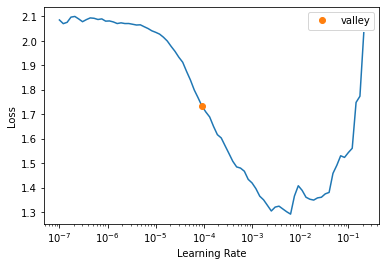

In [ ]:
lr = tuner.lr_find()

It recommends a learning rate of around 1e-4, so we will use that.

Let's look at the documentation for `tune`:

In [ ]:
show_doc(TokenClassificationTuner.tune)

<h4 id="AdaptiveTuner.tune" class="doc_header"><code>AdaptiveTuner.tune</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L399" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.tune</code>(**`epochs`**:`int`, **`lr`**:`float`=*`None`*, **`strategy`**:`Strategy`=*`'fit_one_cycle'`*, **`callbacks`**:`list`=*`[]`*, **\*\*`kwargs`**)

Fine tune `self.model` for `epochs` with an `lr` and `strategy`

**Parameters:**


 - **`epochs`** : *`<class 'int'>`*	<p>Number of iterations to train for</p>


 - **`lr`** : *`<class 'float'>`*, *optional*	<p>If None, finds a new learning rate and uses suggestion_method</p>


 - **`strategy`** : *`<class 'fastcore.basics.Strategy'>`*, *optional*	<p>A fitting method</p>


 - **`callbacks`** : *`<class 'list'>`*, *optional*	<p>Extra fastai Callbacks</p>


 - **`kwargs`** : *`<class 'inspect._empty'>`*


We can pass in a number of epochs, a learning rate, a strategy, and additional fastai callbacks to call.

Valid strategies live in the `Strategy` namespace class, and consist of:
- OneCycle (Also called the [One-Cycle Policy](https://docs.fast.ai/callback.schedule.html#Learner.fit_one_cycle))
- [CosineAnnealing](https://docs.fast.ai/callback.schedule.html#Learner.fit_flat_cos)
- [SGDR](https://docs.fast.ai/callback.schedule.html#Learner.fit_sgdr)

In [ ]:
from adaptnlp import Strategy

In this tutorial we will train with the One-Cycle policy, as currently it is one of the best schedulers to use.

In [ ]:
tuner.tune(3, lr, strategy=Strategy.OneCycle)

epoch     train_loss  valid_loss  accuracy  precision  recall    f1        time    


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0         0.073525    0.059352    0.982763  0.895060   0.908902  0.900667  14:55     
1         0.034628    0.044417    0.987849  0.929728   0.940017  0.934077  14:57     
2         0.009520    0.045935    0.989362  0.943019   0.945272  0.943433  14:57     


## Saving Model

Now that we have a trained model, let's save those weights away.

Calling `tuner.save` will save both the model and the tokenizer in the same format as how HuggingFace does:

In [ ]:
show_doc(TokenClassificationTuner.save)

<h4 id="AdaptiveTuner.save" class="doc_header"><code>AdaptiveTuner.save</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L421" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.save</code>(**`save_directory`**)

Save a pretrained model to a `save_directory`

**Parameters:**


 - **`save_directory`** : *`<class 'inspect._empty'>`*	<p>A folder to save our model to</p>



In [ ]:
tuner.save('good_model')

'good_model'

## Performing Inference

There are two ways to get predictions, the first is with the `.predict` method in our `tuner`. This is great for if you just finished training and want to see how your model performs on some new data!
The other method is with AdaptNLP's inference API, which we will show afterwards

### In Tuner

First let's write a sentence to test with

In [ ]:
sentence = "The company Novetta is based in McLean, Virgina."

And then predict with it:

In [ ]:
show_doc(TokenClassificationTuner.predict)

<h4 id="TokenClassificationTuner.predict" class="doc_header"><code>TokenClassificationTuner.predict</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/token_classification.py#L317" class="source_link" style="float:right">[source]</a></h4>

> <code>TokenClassificationTuner.predict</code>(**`text`**:`Union`\[`List`\[`str`\], `str`\], **`bs`**:`int`=*`64`*, **`grouped_entities`**:`bool`=*`True`*, **`detail_level`**:`DetailLevel`=*`'low'`*)

Predict some `text` for token classification with the currently loaded model

**Parameters:**


 - **`text`** : *`typing.Union[typing.List[str], str]`*	<p>Some text or list of texts to do inference with</p>


 - **`bs`** : *`<class 'int'>`*, *optional*	<p>A batch size to use for multiple texts</p>


 - **`grouped_entities`** : *`<class 'bool'>`*, *optional*	<p>Return whole entity span strings</p>


 - **`detail_level`** : *`<class 'fastcore.basics.DetailLevel'>`*, *optional*	<p>A detail level to return on the predictions</p>



**Returns**:
	
 * *`<class 'dict'>`*	<p>A dictionary of filtered predictions</p>



In [ ]:
tuner.predict(sentence)

OrderedDict([('tags',
              [[{'entity': 'B-ORG',
                 'score': 0.1850021630525589,
                 'word': '[CLS]'},
                {'entity': 'B-ORG', 'score': 0.997603714466095, 'word': 'nov'},
                {'entity': 'I-ORG',
                 'score': 0.9754220247268677,
                 'word': '##etta'},
                {'entity': 'B-LOC',
                 'score': 0.995358407497406,
                 'word': 'mclean'},
                {'entity': 'B-LOC',
                 'score': 0.9764575958251953,
                 'word': 'virgin'}]])])

### With the Inference API

Next we will use the `EasyTokenTagger` class, which AdaptNLP offers:

In [ ]:
from adaptnlp import EasyTokenTagger

We simply construct the class:

In [ ]:
classifier = EasyTokenTagger()

And call the `tag_text` method, passing in the sentence, the location of our saved model, and some names for our classes:

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path='good_model',
)

2021-11-09 23:10:55,157 loading file good_model


OrderedDict([('tags',
              [[{'entity': 'B-ORG',
                 'score': 0.1850021630525589,
                 'word': '[CLS]'},
                {'entity': 'B-ORG', 'score': 0.997603714466095, 'word': 'nov'},
                {'entity': 'I-ORG',
                 'score': 0.9754220247268677,
                 'word': '##etta'},
                {'entity': 'B-LOC',
                 'score': 0.995358407497406,
                 'word': 'mclean'},
                {'entity': 'B-LOC',
                 'score': 0.9764575958251953,
                 'word': 'virgin'}]])])

And we got the exact same output and probabilities!

There are also different levels of predictions we can return (which is also the same with our earlier `predict` call).

These live in a namespace `DetailLevel` class, with a few examples below:

In [ ]:
from adaptnlp import DetailLevel

In [ ]:
DetailLevel.Low

'low'

While some Easy modules will not return different items at each level, most will return only a few specific outputs at the Low level, and everything possible at the High level:

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.Low
)

OrderedDict([('tags',
              [[{'entity': 'B-ORG',
                 'score': 0.1850021630525589,
                 'word': '[CLS]'},
                {'entity': 'B-ORG', 'score': 0.997603714466095, 'word': 'nov'},
                {'entity': 'I-ORG',
                 'score': 0.9754220247268677,
                 'word': '##etta'},
                {'entity': 'B-LOC',
                 'score': 0.995358407497406,
                 'word': 'mclean'},
                {'entity': 'B-LOC',
                 'score': 0.9764575958251953,
                 'word': 'virgin'}]])])

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.Medium
)

OrderedDict([('tags',
              [[{'entity': 'B-ORG',
                 'score': 0.1850021630525589,
                 'word': '[CLS]'},
                {'entity': 'B-ORG', 'score': 0.997603714466095, 'word': 'nov'},
                {'entity': 'I-ORG',
                 'score': 0.9754220247268677,
                 'word': '##etta'},
                {'entity': 'B-LOC',
                 'score': 0.995358407497406,
                 'word': 'mclean'},
                {'entity': 'B-LOC',
                 'score': 0.9764575958251953,
                 'word': 'virgin'}]])])

In [ ]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.High
)

OrderedDict([('tags',
              [[{'entity': 'B-ORG',
                 'score': 0.1850021630525589,
                 'word': '[CLS]'},
                {'entity': 'B-ORG', 'score': 0.997603714466095, 'word': 'nov'},
                {'entity': 'I-ORG',
                 'score': 0.9754220247268677,
                 'word': '##etta'},
                {'entity': 'B-LOC',
                 'score': 0.995358407497406,
                 'word': 'mclean'},
                {'entity': 'B-LOC',
                 'score': 0.9764575958251953,
                 'word': 'virgin'}]])])

## Code Summary

A quick one-cell code chunk with all the code used in this notebook, so the reader can quickly copy/paste this

In [ ]:
from datasets import load_dataset
from adaptnlp import TokenClassificationDatasets
from adaptnlp import TokenClassificationTuner
from adaptnlp import Strategy
from adaptnlp import NERMetric

dsets = load_dataset('conll2003')

dset = dsets['train']
dset.set_format(type='pandas')
df = dset[:]
df = df[['tokens', 'ner_tags']]

model_name = 'distilbert-base-uncased'

tokenize_kwargs = {
    'truncation':True, 
    'is_split_into_words':True, 
    'padding':'max_length', 
    'return_offsets_mapping':True
}

entity_mapping = {
    0: 'O',
    1: 'B-PER',
    2: 'I-PER',
    3: 'B-ORG',
    4: 'I-ORG',
    5: 'B-LOC',
    6: 'I-LOC',
    7: 'B-MISC',
    8: 'I-MISC'
}

dsets = TokenClassificationDatasets.from_dfs(
    df,
    'tokens',
    'ner_tags',
    entity_mapping,
    tokenizer_name = model_name,
    tokenize=True,
    tokenize_kwargs = tokenize_kwargs,
    split_pct=.2
)

dls = dsets.dataloaders(batch_size=8)

tuner = TokenClassificationTuner(dls, model_name)

tuner = TokenClassificationTuner(dls, model_name, metrics=[NERMetric.Accuracy,
                                                           NERMetric.Precision,
                                                           NERMetric.Recall,
                                                           NERMetric.F1])

lr = tuner.lr_find()

tuner.tune(3, lr, strategy=Strategy.OneCycle)

tuner.save('good_model')